In [ ]:
# run below if you don't have any of the packages
#!pip install gym
#!pip install torch
#!pip install torchvision

In [2]:
# import general libraries
import warnings
import time 
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# build q-net
class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 40)
        self.fc1.weight.data.normal_(0, 0.01)
        
        self.out = nn.Linear(40, n_outputs)
        self.out.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value


In [4]:
# build class for CartPole based on OpenAI
class CartPole(object):
    def __init__(self, height = 84, width = 84, seed = 0):
        self.height = height
        self.width = width
        self.env = gym.make("CartPole-v1").unwrapped
        self.env.seed(seed)
        self.n_actions = self.env.action_space.n
        self.x_threshold = self.env.x_threshold
        self.theta_threshold_radians = self.env.theta_threshold_radians
    
    def render(self):
        self.env.render()
    
    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        return observation, reward, done
    
    def reset(self,):
        observation = self.env.reset()
        return observation
    
    def close(self):
        self.env.close()
        

In [5]:
# build replay buffer
class ReplayBuffer(object):
    def __init__(self, capacity = 50000):
        self.capacity = capacity
        self.buffer = []
        self.index = 0
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def save(self, s, a, r, s_, done):
        if len(self.buffer) <= self.capacity:
            self.buffer.append((s, a, r, s_, done))
        else:
            self.buffer[self.index % self.capacity] = (s, a, r, s_, done)
        self.index += 1
    

In [6]:
# build agent
class DQN(object):
    def __init__(self):
        self.eval_net = Net(4, 2)
        self.target_net = Net(4, 2)
        self.buffer = ReplayBuffer(2000)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr = lr)
        self.loss_func = nn.MSELoss()
        self.counter = 0
        
    def select(self, observation):
        observation = torch.unsqueeze(torch.FloatTensor(observation), 0)
        if np.random.uniform() > epsilon: 
            actions_value = self.eval_net.forward(observation)
            action = torch.max(actions_value, 1)[1].data.numpy()[0]
        else:   
            action = np.random.randint(0, 2)
        return action

    def learn(self, al = "ddqn"):
        if self.counter % max_iter == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.counter += 1
        
        samples = self.buffer.sample(batch_size)
        samples = list(zip(*samples))
        s = torch.FloatTensor(np.array(samples[0]))
        a = torch.LongTensor(np.array(samples[1]).reshape(-1, 1).astype(int))
        r = torch.FloatTensor(np.array(samples[2]).reshape(-1, 1))
        s_ = torch.FloatTensor(np.array(samples[3]))
        done = torch.LongTensor(np.array(samples[4]).reshape(-1, 1).astype(int))
        
        q_eval = self.eval_net(s).gather(1, a)
        q_next = self.target_net(s_).view(batch_size, 2).detach() 
        if al == "ddqn":
            q_next_ = self.eval_net(s_).view(batch_size, 2)
            q_target = r + gamma * q_next.gather(1, q_next_.max(1)[1].view(batch_size, 1))
            q_target_ = torch.where(done == 1, r, q_target)
        elif al == "dqn":
            q_target = r + gamma * q_next.max(1)[0].view(batch_size, 1)
            q_target_ = torch.where(done == 1, r, q_target)
            
        loss = self.loss_func(q_eval, q_target_)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def save(self):
        torch.save({
                    'model_state_dict': self.eval_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': self.loss_func
                    }, "dqn_e.pkl"
        )
        torch.save({
                    'model_state_dict': self.target_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': self.loss_func
                    }, "dqn_t.pkl"
        )
    
    def load(self):
        ch_eval = torch.load("ddqn_e.pkl")
        ch_targ = torch.load("ddqn_t.pkl")
        self.eval_net.load_state_dict(ch_eval['model_state_dict'])
        self.target_net.load_state_dict(ch_targ['model_state_dict'])
        self.optimizer.load_state_dict(ch_eval['optimizer_state_dict'])
        

In [7]:
# moving average
def moving_avr(array, n = 5):
    sum = 0
    result = list(0 for x in array)

    for i in range(0, n):
        sum += array[i]
        result[i] = sum / (i + 1)

    for i in range(n, len(array)):
        sum = sum - array[i - n] + array[i]
        result[i] = sum / n

    return result

def cumu_avr(array):
    sum = 0
    result = list(0 for x in array)
    
    for i in range(0, len(array)):
        sum += array[i]
        result[i] = sum / (i + 1)
    
    return result

# plot trend
def plot(data, title):
    x = np.arange(1, len(data) + 1)
    y = np.array(data)
    f = moving_avr(y, 10)
    g = cumu_avr(y)
    
    plt.figure(figsize = (14, 8))
    plt.scatter(x, y, c = 'k', s = 10)
    p1, = plt.plot(x, f, c = 'r')
    p2, = plt.plot(x, g, c = 'b')
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend([p1, p2], ["moving average", "cumulative average"])
    plt.grid()
    plt.show()

In [8]:
# Hyper Parameters
batch_size = 32             # batch size
lr = 0.005                  # learning rate
epsilon = 1.                # greedy policy
gamma = 0.99                # reward discount
max_iter = 100              # target update frequency
scores = []

In [10]:
# build trainer
env = CartPole()
dqn = DQN()
if __name__ == "__main__":
    print("If you wanna train, please enter 'train'; if you wanna see the trained result, please enter 'run'.")
    mode = input("Mode Selection: ")
    if mode == "train":
        start_time = time.time()
        timestamp = 0
        episode = 0
        print('\nCollecting experience...')
        while episode < 800:
            episode += 1
            s = env.reset()
            ac_r = 0
            while True:
                env.render()
                #if timestamp % 4000 == 0:
                    #dqn.save()
                # take an action
                a = dqn.select(s)
                s_, r, done = env.step(a)  
                # modified reward
                
                x, x_dot, theta, theta_dot = s_
                r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
                r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
                r = r1 + r2
                
                # save
                dqn.buffer.save(s, a, r, s_, done)
                ac_r += r
                # start learning when observation is enough
                if dqn.buffer.index > dqn.buffer.capacity:
                    # epsilon update
                    if epsilon > 0.1:
                        epsilon -= 0.9 / 20000
                    dqn.learn("dqn")
                    if done or ac_r > 500:
                        print('Ep: ', episode, '| Ep_r: ', round(ac_r, 2), 
                              '| Epsilon: ', round(epsilon, 6))
                timestamp += 1
                if done or ac_r > 500:
                    break
                s = s_
            scores.append(ac_r)
        print("\nTraining finished.")
        print("\nTotal Runtime:", time.time() - start_time, "seconds") 
    elif mode == "run":
        epsilon = .1
        s = env.reset()
        dqn.load()
        start = time.time()
        while True:   
            env.render()
            a = dqn.select(s)
            s_, r, done = env.step(a)
            s = s_
            if done or time.time() - start > 120:
                break
        print("Demo finished.")
    else:
        print("Error.")

If you wanna train, please enter 'train'; if you wanna see the trained result, please enter 'run'.


Mode Selection:  run


Demo finished.


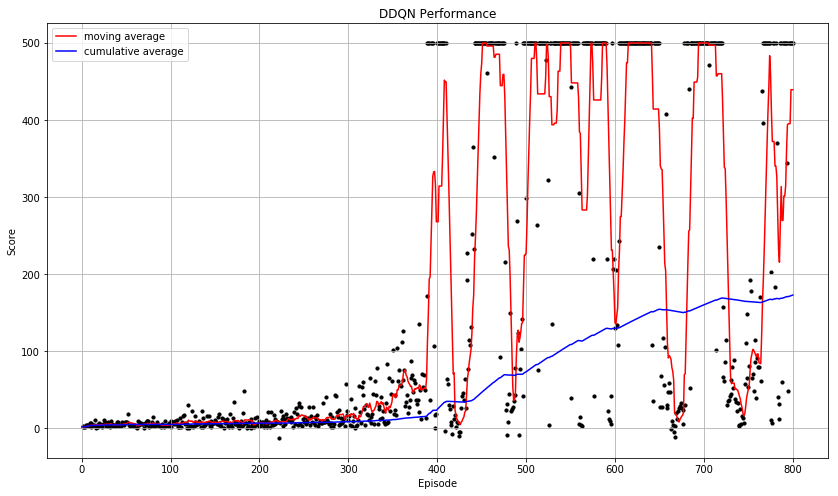

In [10]:
plot(scores, "DDQN Performance")

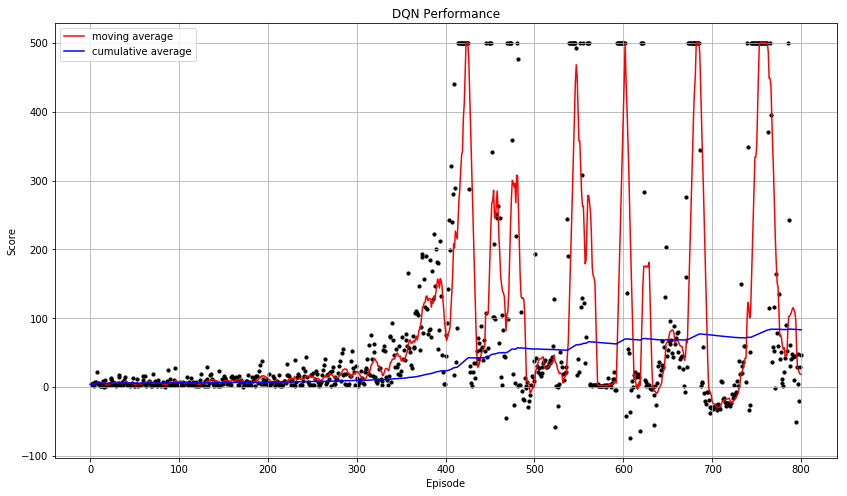

In [12]:
plot(scores, "DQN Performance")